In [1]:
import numpy as np
from itertools import combinations
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## 1. Include the soft-biometric information available in the recognition process. 

In [2]:
# Load your data 
X = np.load('Data/ds_colorferet_emb.npy', allow_pickle=True)
identities = np.load('Data/ds_colorferet_identities.npy', allow_pickle=True)
gender = np.load('Data/ds_colorferet_gender.npy', allow_pickle=True)
ethnicity = np.load('Data/ds_colorferet_ethnicity.npy', allow_pickle=True)
age = np.load('Data/ds_colorferet_age.npy', allow_pickle=True)

In [3]:
#use the functions implemented last week to compute the ROC curve on the whole data, without using soft biometric attributes
def createGenuineIDs(identities):
    """Create genuine ID_sets
    """
    genuine_ID_sets = []
    for i in set(identities):
        idx = np.argwhere(identities==i)
        genuine_ID_sets.append(idx)
    return genuine_ID_sets
    #in each list we have all positions referring to the same identity

def createImposterIDs(identities, num_imposter=10):
    np.random.seed(1)
    imposter_ID_sets = []
    for i in set(identities):
        idx = np.argwhere(identities!=i)
        np.random.shuffle(idx)
        idx_reduced = idx[:num_imposter]
        imposter_ID_sets.append(idx_reduced)
    return imposter_ID_sets
    #in each list we have 10 positions referring to different identities

def cos_sim(a,b):
    """ Cosine similarity between vector a and b
    """
    a, b = a.reshape(-1), b.reshape(-1)
    return np.dot(a,b) / (np.linalg.norm(a) * np.linalg.norm(b))

def computeScores(ID_sets, X, sim_fct):
    scores = []
    for i in range(len(ID_sets)):
        combs = combinations(ID_sets[i], 2)
        for comb in combs:
            x_probe, x_ref = X[comb[0],:], X[comb[1],:]
            score = sim_fct(x_probe, x_ref)
            scores.append(score) 
    return np.array(scores)

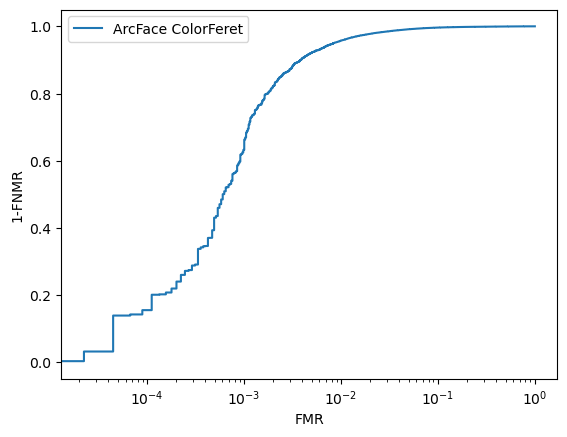

In [5]:
#plot ROC curve for the data
gen_pairs = createGenuineIDs(identities)
imp_pairs =  createImposterIDs(identities)
genuine_scores = computeScores(gen_pairs, X, cos_sim)
imposter_scores = computeScores(imp_pairs, X, cos_sim)

gen_id = np.ones(len(genuine_scores))
imp_id = np.zeros(len(imposter_scores))
# merged      
scores = np.hstack([genuine_scores, imposter_scores])
labels = np.hstack([gen_id, imp_id])

fpr, tpr, thresholds = roc_curve(labels, scores)

# plot ROC
plt.figure()
plt.plot(fpr, tpr, label="ArcFace ColorFeret")
plt.xlabel("FMR")
plt.ylabel("1-FNMR")
plt.xscale("log")
plt.legend()

plt.show()

In [6]:
#create a new function for the comparison scores that includes also soft biometric attributes
def new_computeScores(ID_sets, X, gender, ethnicity, sim_fct):
    scores = []
    for i in range(len(ID_sets)):
        combs = combinations(ID_sets[i], 2)
        for comb in combs:
            x_probe, x_ref = X[comb[0], :], X[comb[1], :]
            if gender[comb[0]] != gender[comb[1]] or ethnicity[comb[0]] != ethnicity[comb[1]]:
                scores.append(-1)
            score = sim_fct(x_probe, x_ref)
            scores.append(score)
    return np.array(scores)

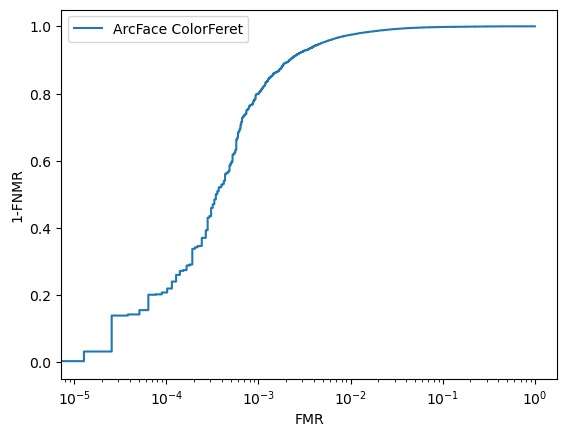

In [7]:
#plot the new ROC curve
genuine_scores = new_computeScores(gen_pairs, X, gender, ethnicity, cos_sim)
imposter_scores = new_computeScores(imp_pairs, X, gender, ethnicity, cos_sim)

gen_id = np.ones(len(genuine_scores))
imp_id = np.zeros(len(imposter_scores))
# merged      
scores = np.hstack([genuine_scores, imposter_scores])
labels = np.hstack([gen_id, imp_id])

fpr, tpr, thresholds = roc_curve(labels, scores)

# plot ROC
plt.figure()
plt.plot(fpr, tpr, label="ArcFace ColorFeret")
plt.xlabel("FMR")
plt.ylabel("1-FNMR")
plt.xscale("log")
plt.legend()

plt.show()

Assuming that the labels are correct and consistent, the performance should increase since we can not make mistakes for those comparisons.
Having already a good performance before, the improvement is hard to see in this case. However, including spft-biometric attributes generally increases the FR performance

## 2.	What do you think if of including age or accessory information (wearing a hat, makeup, etc.) in the process? 

For comparison samples that were captured in a short period of time, the approach might work. However, since age and accessories can change between different captures, one must be careful to use these soft-biometric attributes to boost performance. 